# Tutorial 0: introduction.

Welcome to the series of tutorial explaining how to use VANs. In this tutorial we will go through the basics: define a circuit as an indexed list of gates, show the circuit, and finally apply VQE algorithm so to prepare an (approximate version of) the ground-state of a Trasnverse Field Ising Model.

In [3]:
%load_ext autoreload
%autoreload 2
import tensorflow_quantum as tfq
import matplotlib.pyplot as plt
import cirq
import numpy as np

import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
    
print("USING TFQ {} VERSION ".format(tfq.__version__))
print("USING CIRQ {} VERSION ".format(cirq.__version__))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
USING TFQ 0.4.0 VERSION 
USING CIRQ 0.9.1 VERSION 


Basic functions and definitions, such as number of qubits, gate indexing and quantum circuit construction, are defined in the $\texttt{Basics}$ class, which can be found at <i>circuit_basics.py</i>,  Gate arangement is defined according to list of indices. Each gate is given an index (which depends on the number of qubits of the cirucit). This indexing consists first on all possible CNOTS, then $Rz$ rotations, $Rx$ rotations and $Ry$ rotations.

In [4]:
from utilities.circuit_basics import Basic
basics = Basic(n_qubits=4)
for k in range(basics.number_of_cnots + 3*basics.n_qubits):
    print("Index {}".format(k))
    display(basics.give_circuit([k])[0])
    print("\n")


Index 0


(0, 0): ───@───
           │
(0, 1): ───X───



Index 1


(0, 0): ───@───
           │
(0, 2): ───X───



Index 2


(0, 0): ───@───
           │
(0, 3): ───X───



Index 3


(0, 0): ───X───
           │
(0, 1): ───@───



Index 4


(0, 1): ───@───
           │
(0, 2): ───X───



Index 5


(0, 1): ───@───
           │
(0, 3): ───X───



Index 6


(0, 0): ───X───
           │
(0, 2): ───@───



Index 7


(0, 1): ───X───
           │
(0, 2): ───@───



Index 8


(0, 2): ───@───
           │
(0, 3): ───X───



Index 9


(0, 0): ───X───
           │
(0, 3): ───@───



Index 10


(0, 1): ───X───
           │
(0, 3): ───@───



Index 11


(0, 2): ───X───
           │
(0, 3): ───@───



Index 12


(0, 0): ───Rz(th_0)───



Index 13


(0, 1): ───Rz(th_0)───



Index 14


(0, 2): ───Rz(th_0)───



Index 15


(0, 3): ───Rz(th_0)───



Index 16


(0, 0): ───Rx(th_0)───



Index 17


(0, 1): ───Rx(th_0)───



Index 18


(0, 2): ───Rx(th_0)───



Index 19


(0, 3): ───Rx(th_0)───



Index 20


(0, 0): ───Ry(th_0)───



Index 21


(0, 1): ───Ry(th_0)───



Index 22


(0, 2): ───Ry(th_0)───



Index 23


(0, 3): ───Ry(th_0)───

Attributes defined in $\texttt{Basic}$ class are inherited by other classes, such as the $\texttt{VQE}$ class, which can be found in <i>variational.py</i>.

$\texttt{VQE}$ needs to be fed with a problem_config dictionary, which in turn defines the Hamiltonian of the problem. Let us inspect how to do this with the Transverse Field Ising Model (TFIM), whose Hamiltonian is


$H=-J\sum_{j=1}^n \sigma_j^x\sigma_{j+1}^x-g\sum_{j=1}^n \sigma_j^x\,,$

In [3]:
from utilities.variational import VQE 
problem_config={"problem":"TFIM", "J":1.0, "g":1.0}

vqe_handler = VQE(n_qubits=4, epochs=2000, 
                  verbose=1,problem_config=problem_config,
                  optimizer="adam", lr=0.001)


Here, we have also defined the classical optimizer (Adam in this case) to be used to train the circuit, as well as specified the epochs which are the number of gradient descent iterations when running the VQE algorithm (although there's an early-stopping mechanism if cost is no longer getting down).

Internally, TFIM Hamiltonian is defined as a list of (correspondin weigths and) Pauli Observables, whose expected value is advantageous to be computed with a quantum device.

For instance, the Hamiltonian can be acceded as

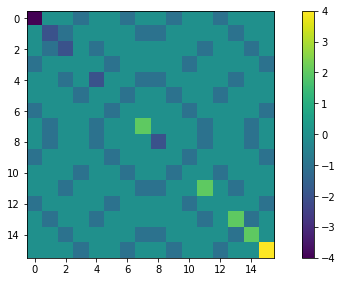

In [4]:
H=sum(vqe_handler.observable).matrix()
fig=plt.figure(figsize=(10,10))
plt.subplot(211)
im=plt.imshow(np.real(H))
cbar=fig.colorbar(im)

In [90]:
### Let's compute the ground-state:

eigs = np.linalg.eigh(H)
ground_state_energy = eigs[0][0]
ground_state = eigs[1][:,0]

Now let us train a fixed-structure cirucit to prepare the ground state of this Hamiltonian, using a Hardware Efficient Ansatz.

In [8]:
indexed_circuit = basics.hea_ansatz_indexed_circuit(L=6)
vqe_handler.give_circuit(indexed_circuit)[0]

┌──┐                                                       ┌──┐                                                       ┌──┐
(0, 0): ───Rx(th_0)───Rz(th_1)───@───Rx(th_8)────Rz(th_9)──────X────Rx(th_16)───Rz(th_17)───@───Rx(th_24)───Rz(th_25)─────X────Rx(th_32)───Rz(th_33)───@───Rx(th_40)───Rz(th_41)─────X────
                                 │                             │                            │                             │                            │                             │
(0, 1): ───Rx(th_2)───Rz(th_3)───X───Rx(th_10)───Rz(th_11)────@┼────Rx(th_18)───Rz(th_19)───X───Rx(th_26)───Rz(th_27)────@┼────Rx(th_34)───Rz(th_35)───X───Rx(th_42)───Rz(th_43)────@┼────
                                                              ││                                                         ││                                                         ││
(0, 2): ───Rx(th_4)───Rz(th_5)───@───Rx(th_12)───Rz(th_13)────X┼────Rx(th_20)───Rz(th_21)───@───Rx(th_28)───Rz(th_29)────X┼────Rx(th_36)───Rz(th_37)───@───Rx(th_44)───Rz(th_45)────X┼────
                                 │                             │                            │                             │                            │                             │
(0, 3): ───Rx(th_6)───Rz(th_7)───X───Rx(th_14)───Rz(th_15)─────@────Rx(th_22)───Rz(th_23)───X───Rx(th_30)───Rz(th_31)─────@────Rx(th_38)───Rz(th_39)───X───Rx(th_46)───Rz(th_47)─────@────
                                                             └──┘                                                       └──┘                                                       └──┘

Let's train this cirucit to prepare the grund state!

In [9]:
vqe_handler = VQE(n_qubits=4, epochs=10000, 
                  verbose=1,problem_config=problem_config,
                  optimizer="adam", lr=1e-2, patience=100)

energy, resolver, training_history = vqe_handler.vqe(indexed_circuit)

Epoch 1/10000
1/1 [==============================] - 0s 872us/step - energy: -0.2468 - lr: 0.0100 - grad_norm: 7.1521
Epoch 2/10000
1/1 [==============================] - 0s 1ms/step - energy: -0.3943 - lr: 0.0100 - grad_norm: 7.2488
Epoch 3/10000
1/1 [==============================] - 0s 1ms/step - energy: -0.5406 - lr: 0.0100 - grad_norm: 7.3292
Epoch 4/10000
1/1 [==============================] - 0s 3ms/step - energy: -0.6851 - lr: 0.0100 - grad_norm: 7.4073
Epoch 5/10000
1/1 [==============================] - 0s 1ms/step - energy: -0.8282 - lr: 0.0100 - grad_norm: 7.4926
Epoch 6/10000
1/1 [==============================] - 0s 1ms/step - energy: -0.9705 - lr: 0.0100 - grad_norm: 7.5845
Epoch 7/10000
1/1 [==============================] - 0s 1ms/step - energy: -1.1130 - lr: 0.0100 - grad_norm: 7.6718
Epoch 8/10000
1/1 [==============================] - 0s 1ms/step - energy: -1.2557 - lr: 0.0100 - grad_norm: 7.7404
Epoch 9/10000
1/1 [==============================] - 0s 991us/step - e

1/1 [==============================] - 0s 1ms/step - energy: -4.9824 - lr: 0.0100 - grad_norm: 0.0226
Epoch 140/10000
1/1 [==============================] - 0s 2ms/step - energy: -4.9839 - lr: 0.0100 - grad_norm: 0.0224
Epoch 141/10000
1/1 [==============================] - 0s 1ms/step - energy: -4.9854 - lr: 0.0100 - grad_norm: 0.0222
Epoch 142/10000
1/1 [==============================] - 0s 2ms/step - energy: -4.9868 - lr: 0.0100 - grad_norm: 0.0220
Epoch 143/10000
1/1 [==============================] - 0s 2ms/step - energy: -4.9883 - lr: 0.0100 - grad_norm: 0.0218
Epoch 144/10000
1/1 [==============================] - 0s 1ms/step - energy: -4.9897 - lr: 0.0100 - grad_norm: 0.0216
Epoch 145/10000
1/1 [==============================] - 0s 2ms/step - energy: -4.9912 - lr: 0.0100 - grad_norm: 0.0214
Epoch 146/10000
1/1 [==============================] - 0s 1ms/step - energy: -4.9927 - lr: 0.0100 - grad_norm: 0.0212
Epoch 147/10000
1/1 [==============================] - 0s 2ms/step - ene

1/1 [==============================] - 0s 2ms/step - energy: -5.1975 - lr: 0.0100 - grad_norm: 0.0072
Epoch 278/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.1983 - lr: 0.0100 - grad_norm: 0.0069
Epoch 279/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.1991 - lr: 0.0100 - grad_norm: 0.0066
Epoch 280/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.1999 - lr: 0.0100 - grad_norm: 0.0063
Epoch 281/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2006 - lr: 0.0100 - grad_norm: 0.0060
Epoch 282/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2013 - lr: 0.0100 - grad_norm: 0.0058
Epoch 283/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2020 - lr: 0.0100 - grad_norm: 0.0055
Epoch 284/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2027 - lr: 0.0100 - grad_norm: 0.0053
Epoch 285/10000
1/1 [==============================] - 0s 2ms/step - ene

1/1 [==============================] - 0s 4ms/step - energy: -5.2203 - lr: 0.0100 - grad_norm: 1.8633e-04
Epoch 413/10000
1/1 [==============================] - 0s 4ms/step - energy: -5.2203 - lr: 0.0100 - grad_norm: 1.8356e-04
Epoch 414/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2204 - lr: 0.0100 - grad_norm: 1.8214e-04
Epoch 415/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2204 - lr: 0.0100 - grad_norm: 1.7924e-04
Epoch 416/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2204 - lr: 0.0100 - grad_norm: 1.7859e-04
Epoch 417/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2204 - lr: 0.0100 - grad_norm: 1.7802e-04
Epoch 418/10000
1/1 [==============================] - 0s 4ms/step - energy: -5.2205 - lr: 0.0100 - grad_norm: 1.7453e-04
Epoch 419/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2205 - lr: 0.0100 - grad_norm: 1.7247e-04
Epoch 420/10000
1/1 [===================

1/1 [==============================] - 0s 3ms/step - energy: -5.2225 - lr: 0.0100 - grad_norm: 7.8142e-05
Epoch 547/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2225 - lr: 0.0100 - grad_norm: 7.7542e-05
Epoch 548/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2225 - lr: 0.0100 - grad_norm: 7.6444e-05
Epoch 549/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2225 - lr: 0.0100 - grad_norm: 7.7070e-05
Epoch 550/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2226 - lr: 0.0100 - grad_norm: 7.6193e-05
Epoch 551/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2226 - lr: 0.0100 - grad_norm: 7.5031e-05
Epoch 552/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2226 - lr: 0.0100 - grad_norm: 7.5264e-05
Epoch 553/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2226 - lr: 0.0100 - grad_norm: 7.4407e-05
Epoch 554/10000
1/1 [===================

1/1 [==============================] - 0s 2ms/step - energy: -5.2238 - lr: 0.0100 - grad_norm: 4.0356e-05
Epoch 681/10000
1/1 [==============================] - 0s 4ms/step - energy: -5.2239 - lr: 0.0100 - grad_norm: 4.0541e-05
Epoch 682/10000
1/1 [==============================] - 0s 4ms/step - energy: -5.2239 - lr: 0.0100 - grad_norm: 4.0593e-05
Epoch 683/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2239 - lr: 0.0100 - grad_norm: 4.0331e-05
Epoch 684/10000
1/1 [==============================] - 0s 1ms/step - energy: -5.2239 - lr: 0.0100 - grad_norm: 4.0401e-05
Epoch 685/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2239 - lr: 0.0100 - grad_norm: 3.9328e-05
Epoch 686/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2239 - lr: 0.0100 - grad_norm: 3.9996e-05
Epoch 687/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2239 - lr: 0.0100 - grad_norm: 3.9716e-05
Epoch 688/10000
1/1 [===================

1/1 [==============================] - 0s 4ms/step - energy: -5.2247 - lr: 0.0100 - grad_norm: 2.1463e-05
Epoch 815/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2247 - lr: 0.0100 - grad_norm: 2.2194e-05
Epoch 816/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2247 - lr: 0.0100 - grad_norm: 2.1984e-05
Epoch 817/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2247 - lr: 0.0100 - grad_norm: 2.2131e-05
Epoch 818/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2248 - lr: 0.0100 - grad_norm: 2.1342e-05
Epoch 819/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2248 - lr: 0.0100 - grad_norm: 2.1037e-05
Epoch 820/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2248 - lr: 0.0100 - grad_norm: 2.1512e-05
Epoch 821/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2248 - lr: 0.0100 - grad_norm: 2.1268e-05
Epoch 822/10000
1/1 [===================

1/1 [==============================] - 0s 3ms/step - energy: -5.2253 - lr: 0.0100 - grad_norm: 1.1787e-05
Epoch 948/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2253 - lr: 0.0100 - grad_norm: 1.1637e-05
Epoch 949/10000
1/1 [==============================] - 0s 4ms/step - energy: -5.2253 - lr: 0.0100 - grad_norm: 1.1562e-05
Epoch 950/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2253 - lr: 0.0100 - grad_norm: 1.1959e-05
Epoch 951/10000
1/1 [==============================] - 0s 4ms/step - energy: -5.2253 - lr: 0.0100 - grad_norm: 1.1717e-05
Epoch 952/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2253 - lr: 0.0100 - grad_norm: 1.1797e-05
Epoch 953/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2253 - lr: 0.0100 - grad_norm: 1.1861e-05
Epoch 954/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2253 - lr: 0.0100 - grad_norm: 1.1494e-05
Epoch 955/10000
1/1 [===================

1/1 [==============================] - 0s 5ms/step - energy: -5.2257 - lr: 0.0100 - grad_norm: 6.7101e-06
Epoch 1081/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2257 - lr: 0.0100 - grad_norm: 6.2304e-06
Epoch 1082/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2257 - lr: 0.0100 - grad_norm: 6.5989e-06
Epoch 1083/10000
1/1 [==============================] - 0s 7ms/step - energy: -5.2257 - lr: 0.0100 - grad_norm: 6.5976e-06
Epoch 1084/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2257 - lr: 0.0100 - grad_norm: 6.4544e-06
Epoch 1085/10000
1/1 [==============================] - 0s 5ms/step - energy: -5.2257 - lr: 0.0100 - grad_norm: 6.0697e-06
Epoch 1086/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2257 - lr: 0.0100 - grad_norm: 6.2800e-06
Epoch 1087/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2257 - lr: 0.0100 - grad_norm: 6.5013e-06
Epoch 1088/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - energy: -5.2259 - lr: 0.0100 - grad_norm: 3.7315e-06
Epoch 1213/10000
1/1 [==============================] - 0s 4ms/step - energy: -5.2259 - lr: 0.0100 - grad_norm: 3.8959e-06
Epoch 1214/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2259 - lr: 0.0100 - grad_norm: 3.7561e-06
Epoch 1215/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2259 - lr: 0.0100 - grad_norm: 3.6537e-06
Epoch 1216/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2259 - lr: 0.0100 - grad_norm: 3.7898e-06
Epoch 1217/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2259 - lr: 0.0100 - grad_norm: 3.4014e-06
Epoch 1218/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2259 - lr: 0.0100 - grad_norm: 3.7613e-06
Epoch 1219/10000
1/1 [==============================] - 0s 5ms/step - energy: -5.2259 - lr: 0.0100 - grad_norm: 3.6366e-06
Epoch 1220/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - energy: -5.2260 - lr: 0.0100 - grad_norm: 2.0748e-06
Epoch 1345/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2260 - lr: 0.0100 - grad_norm: 2.0606e-06
Epoch 1346/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2260 - lr: 0.0100 - grad_norm: 2.2257e-06
Epoch 1347/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2260 - lr: 0.0100 - grad_norm: 1.9815e-06
Epoch 1348/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2260 - lr: 0.0100 - grad_norm: 2.1390e-06
Epoch 1349/10000
1/1 [==============================] - 0s 4ms/step - energy: -5.2260 - lr: 0.0100 - grad_norm: 2.0859e-06
Epoch 1350/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2260 - lr: 0.0100 - grad_norm: 2.2479e-06
Epoch 1351/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2260 - lr: 0.0100 - grad_norm: 2.0830e-06
Epoch 1352/10000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - energy: -5.2261 - lr: 0.0100 - grad_norm: 1.1749e-06
Epoch 1477/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2261 - lr: 0.0100 - grad_norm: 1.0611e-06
Epoch 1478/10000
1/1 [==============================] - 0s 4ms/step - energy: -5.2261 - lr: 0.0100 - grad_norm: 1.1760e-06
Epoch 1479/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2261 - lr: 0.0100 - grad_norm: 1.2899e-06
Epoch 1480/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2261 - lr: 0.0100 - grad_norm: 1.1723e-06
Epoch 1481/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2261 - lr: 0.0100 - grad_norm: 1.1587e-06
Epoch 1482/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2261 - lr: 0.0100 - grad_norm: 1.1826e-06
Epoch 1483/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2261 - lr: 0.0100 - grad_norm: 1.2094e-06
Epoch 1484/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 6.6739e-07
Epoch 1609/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 6.7435e-07
Epoch 1610/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 7.0141e-07
Epoch 1611/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 6.8747e-07
Epoch 1612/10000
1/1 [==============================] - 0s 8ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 7.0809e-07
Epoch 1613/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 5.9016e-07
Epoch 1614/10000
1/1 [==============================] - 0s 4ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 6.4525e-07
Epoch 1615/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 6.4339e-07
Epoch 1616/10000
1/1 [===========

1/1 [==============================] - 0s 3ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 3.8900e-07
Epoch 1741/10000
1/1 [==============================] - 0s 1ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 4.1253e-07
Epoch 1742/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 4.3556e-07
Epoch 1743/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 3.7583e-07
Epoch 1744/10000
1/1 [==============================] - 0s 4ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 4.0181e-07
Epoch 1745/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 3.2974e-07
Epoch 1746/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 3.6756e-07
Epoch 1747/10000
1/1 [==============================] - 0s 4ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 4.1799e-07
Epoch 1748/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 2.3379e-07
Epoch 1873/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 2.5510e-07
Epoch 1874/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 2.6068e-07
Epoch 1875/10000
1/1 [==============================] - 0s 4ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 2.4436e-07
Epoch 1876/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 2.0519e-07
Epoch 1877/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 1.9764e-07
Epoch 1878/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 1.9403e-07
Epoch 1879/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 2.4194e-07
Epoch 1880/10000
1/1 [===========

1/1 [==============================] - 0s 6ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 1.0969e-07
Epoch 2005/10000
1/1 [==============================] - 0s 1ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 1.6989e-07
Epoch 2006/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 1.2323e-07
Epoch 2007/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 1.9320e-07
Epoch 2008/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 1.5628e-07
Epoch 2009/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 1.8288e-07
Epoch 2010/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 1.7002e-07
Epoch 2011/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 1.8815e-07
Epoch 2012/10000
1/1 [===========

1/1 [==============================] - 0s 4ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 1.1870e-07
Epoch 2137/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 7.8831e-08
Epoch 2138/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 1.2049e-07
Epoch 2139/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 8.9264e-08
Epoch 2140/10000
1/1 [==============================] - 0s 4ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 9.9597e-08
Epoch 2141/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 1.4254e-07
Epoch 2142/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 1.1771e-07
Epoch 2143/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 1.1474e-07
Epoch 2144/10000
1/1 [===========

1/1 [==============================] - 0s 2ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 6.5396e-08
Epoch 2269/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 1.2952e-07
Epoch 2270/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 8.8729e-08
Epoch 2271/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 1.0315e-07
Epoch 2272/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 2.1490e-07
Epoch 2273/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 8.0297e-08
Epoch 2274/10000
1/1 [==============================] - 0s 3ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 1.4622e-07
Epoch 2275/10000
1/1 [==============================] - 0s 2ms/step - energy: -5.2262 - lr: 0.0100 - grad_norm: 1.0853e-07
Epoch 2276/10000
1/1 [===========

Text(0, 0.5, 'Difference w/ \nground state energy')

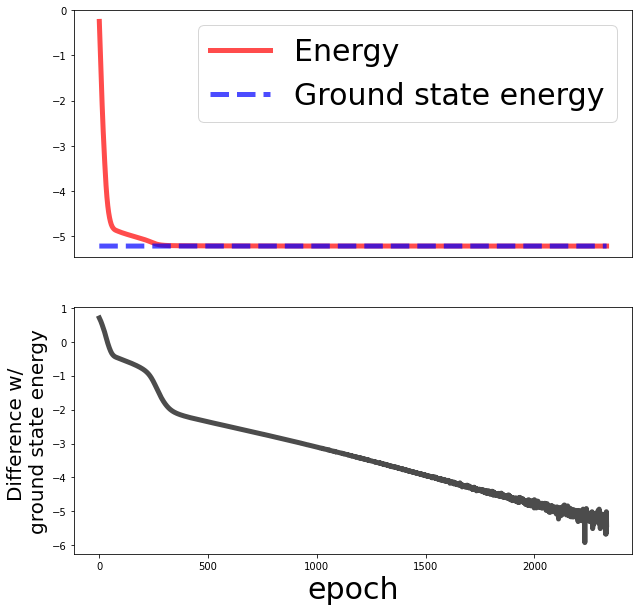

In [42]:
lw=5
ls=30
plt.figure(figsize=(10,10))
plt.subplot(211)
plt.plot(training_history.history["energy"], linewidth=lw, alpha=0.7, color="red", label="Energy")
plt.plot(np.ones(len(training_history.history["energy"]))*ground_state_energy, '--', linewidth=lw, alpha=0.7, color="blue", label="Ground state energy")
plt.xticks([])
plt.legend(prop={"size":30})
plt.subplot(212)
plt.plot(np.log10(np.abs(training_history.history["energy"] - ground_state_energy)),  linewidth=lw, alpha=0.7, color="black")
plt.xlabel("epoch",size=ls)
plt.ylabel("Difference w/ \nground state energy",size=int(ls/1.5))


Seems like the circuit has been trained quite good! Let us now inspect how the prepared state differs from the ground state.

In [91]:
U = cirq.unitary(vqe_handler.give_unitary(indexed_circuit, resolver))
state = U[:,0] #This is becuase we apply the cirucit to the fiducial state |0>^n

In [93]:
def overlap(st1, st2):
    return np.dot(np.conjugate(st1), st2)

In [102]:
print("Fidelity: {}".format(np.abs(overlap(ground_state, state))))

Fidelity: 0.9999961073218325


To sum up, we have applied the VQE algorithm to a Hardware Efficient Ansatz so to prepare an approximate version of the ground-state for a TFIM. Note that the number of layers is quite high (you can try to see how energy accuracy changes as the number of HEA-layers changes!)

In [108]:
print("The circuit under study has {} CNOTS and {} rotations".format(vqe_handler.count_cnots(indexed_circuit), vqe_handler.count_params(indexed_circuit)))

The circuit under study has 12 CNOTS and 48 rotations
